In [1]:
from pymongo import MongoClient

In [2]:
mongo_client = MongoClient('34.209.155.42', 27016)
database_reference = mongo_client.twitter
tweet_collection = database_reference.tweets

In [73]:
cursor_sample = collection_reference.aggregate([{'$sample': {'size': 5000}}])

In [74]:
tweets = list(cursor_sample)

In [75]:
all_keys = set()
for tweet in tweets:
    user = tweet['user']
    keys = list(user.keys())
    all_keys = all_keys.union(keys)

In [76]:
all_keys

{'contributors_enabled',
 'created_at',
 'default_profile',
 'default_profile_image',
 'description',
 'favourites_count',
 'follow_request_sent',
 'followers_count',
 'following',
 'friends_count',
 'geo_enabled',
 'id',
 'id_str',
 'is_translator',
 'lang',
 'listed_count',
 'location',
 'name',
 'notifications',
 'profile_background_color',
 'profile_background_image_url',
 'profile_background_image_url_https',
 'profile_background_tile',
 'profile_banner_url',
 'profile_image_url',
 'profile_image_url_https',
 'profile_link_color',
 'profile_sidebar_border_color',
 'profile_sidebar_fill_color',
 'profile_text_color',
 'profile_use_background_image',
 'protected',
 'screen_name',
 'statuses_count',
 'time_zone',
 'translator_type',
 'url',
 'utc_offset',
 'verified'}

In [87]:
keep = ['created_at','description','favourites_count','followers_count','friends_count', 'geo_enabled','id_str',
        'lang','location','name','screen_name','statuses_count','time_zone','verified']

In [3]:
import pandas as pd

In [4]:
cursor_sample = tweets_collection.aggregate([{'$sample': {'size': 5}}])

NameError: name 'collection_reference' is not defined

In [ ]:
tweets = pd.DataFrame(list(cursor_sample))

In [90]:
users = pd.DataFrame(list(tweets['user'].values))

In [91]:
users = users[keep].copy() # ask me why I did this
users['created_at'] = pd.to_datetime(users['created_at'])
users

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id_str,lang,location,name,screen_name,statuses_count,time_zone,verified
0,2009-02-06 04:03:06,Toma ✊🏽,18046,633,1246,True,20215868,en,"Venice/West LA, CA",El Florentino,wsbeans,37058,Pacific Time (US & Canada),False
1,2011-10-06 13:58:32,"Jewish, Gay, Opinionated. A whiz in the kitche...",2447,829,2237,True,385992488,en,"Boyle Heights, Los Angeles, CA",dystopian clambake,eclecticthnker,12033,Central Time (US & Canada),False
2,2016-11-14 00:14:07,Upset and sick about what's happening returnin...,155,51,149,True,797955733660647424,en,"Apple Valley, CA",John Perkins,besafeandsmart,2859,None,False
3,2009-11-21 19:59:02,"DONT WORRY, BE HAPPY",3342,2252,1246,True,91641867,en,"New York, NY",Straight No Chaser,letsorderapizza,221006,Pacific Time (US & Canada),False
4,2009-05-14 05:58:02,"Former Underground+Illegal Restaurant, 2 yrs #...",4387,6528,2786,True,39938850,en,"ÜT: 34.163224,-118.369294",Starry Kitchen,starrykitchen,28230,Pacific Time (US & Canada),False


In [2]:
users

NameError: name 'users' is not defined

In [92]:
user_collection = database_reference.users 

In [156]:
def get_n_tweets(n):
    
    n_samples = 0
    tweets = []
    
    filter_on_unprocessed = { '$match' : {
         'user_processed': { "$exists": False } } 
    }
    
    while n_samples < n:
        
        sample = { '$sample': { 'size': n - n_samples } }

        cursor_sample = collection_reference.aggregate([
            sample,
            filter_on_unprocessed
        ])
    
        tweets += list(cursor_sample)
        n_samples = len(tweets)
        
    ids = [tweet['_id'] for tweet in tweets]
        
    return ids, pd.DataFrame(tweets)

def parse_users_from_tweets(tweets):
    users = pd.DataFrame(list(tweets['user'].values))
    users = users[keep].copy()
    users['created_at'] = pd.to_datetime(users['created_at'])
    return users.to_dict('records')
    
def process_users(n=5):
    
    ids, tweets = get_n_tweets(n)
    users = parse_users_from_tweets(tweets)
    
    user_collection.insert_many(users)
    
    tweet_filter_by_id = {'_id' : { '$in' : ids}}
    update = {'$set' : {'user_processed' : True}}
    tweet_collection.update_many(tweet_filter_by_id, update)
    
    return ids


In [158]:
import time

In [180]:
def time_user_processing(n, times):
    start = time.time()
    process_users(n)
    end = time.time() - start
    times.append((n, end))
    return times

In [181]:
times = []
for n in [5,10,20,50,100,200,500,1000]:
    times = time_user_processing(n, times)

In [182]:
times

[(5, 0.3964078426361084),
 (10, 0.40665149688720703),
 (20, 0.41417741775512695),
 (50, 0.49303197860717773),
 (100, 0.591240406036377),
 (200, 1.0646710395812988),
 (500, 1.7654318809509277),
 (1000, 2.3853328227996826)]

In [183]:
import matplotlib.pyplot as plt
import numpy as np

(0, 5)

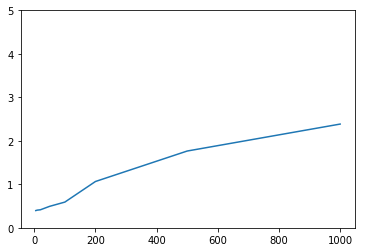

In [185]:
test_results = np.array(times)
plt.plot(test_results[:, 0], test_results[:, 1])
plt.ylim(0,5)

(0, 50)

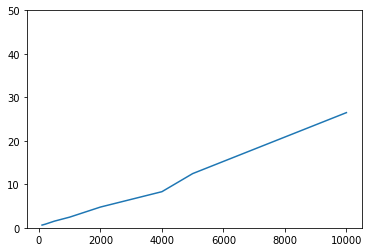

In [190]:
times = []
for n in [100,200,500,1000, 2000, 4000, 5000, 10000]:
    times = time_user_processing(n, times)
    

test_results = np.array(times)
plt.plot(test_results[:, 0], test_results[:, 1])
plt.ylim(0,50)

In [191]:
start = time.time()
process_users(100000)
time.time() - start

240.48823261260986

In [194]:
unprocessed_tweets = tweet_collection.find({'user_processed': { "$exists": False } } )

In [210]:
start = time.time()
process_users(100000)
print(time.time() - start)

280.23269605636597


In [211]:
start = time.time()
process_users(100000)
print(time.time() - start)

325.3904719352722


In [212]:
start = time.time()
process_users(100000)
print(time.time() - start)

337.5805776119232


In [213]:
start = time.time()
process_users(100000)
print(time.time() - start)

AttributeError: 'float' object has no attribute 'keys'

In [ ]:
start = time.time()
process_users(100000)
print(time.time() - start)

In [ ]:
start = time.time()
process_users(100000)
print(time.time() - start)

In [ ]:
start = time.time()
process_users(100000)
print(time.time() - start)

In [ ]:
start = time.time()
process_users(100000)
print(time.time() - start)

In [ ]:
start = time.time()
process_users(100000)
print(time.time() - start)

In [ ]:
start = time.time()
process_users(100000)
print(time.time() - start)

In [ ]:
start = time.time()
process_users(100000)
print(time.time() - start)

In [ ]:
unprocessed_tweets.count()